# Training Classifier Vidmizer

<li>https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</li>

# Classifier 2D Binaire vidmizer sur un Resnet
<p> Le code utilisé est celui de notre précédent classifier qui a été modifié </p>

## Loader

### Gestion de l'accès au drive / import des bibliothèques / Gestion de l'accès au GPU

In [1]:
########## Accès au drive ########
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
########## Positionnement dans le repertoire ########
# %cd /content/drive/MyDrive/TSP/HTI/PFE
#%cd /content/drive/MyDrive/PFE
# !ls /content/drive/MyDrive/TSP/HTI/PFE
!ls /content

drive  sample_data


In [3]:
# !unzip /content/drive/MyDrive/TSP/HTI/PFE/train_vidmizer.zip
# !unzip /content/drive/MyDrive/TSP/HTI/PFE/test_vidmizer.zip
# !unzip /content/train_vidmizer.zip
# !unzip /content/test_vidmizer.zip

!unzip /content/drive/MyDrive/TSP/HTI/PFE/Database_papier/dataset_vidmizer.zip -d /content/
!unzip /content/drive/MyDrive/TSP/HTI/PFE/Database_papier/annotate.zip -d /content/

Archive:  /content/drive/MyDrive/TSP/HTI/PFE/Database_papier/dataset_vidmizer.zip
   creating: /content/dataset_vidmizer/
   creating: /content/dataset_vidmizer/test/
   creating: /content/dataset_vidmizer/train/
  inflating: /content/dataset_vidmizer/test/youtube_video_83_017.png  
  inflating: /content/dataset_vidmizer/test/youtube_video_88_065.png  
  inflating: /content/dataset_vidmizer/test/youtube_video_88_071.png  
  inflating: /content/dataset_vidmizer/test/youtube_video_88_059.png  
  inflating: /content/dataset_vidmizer/test/tiktok_video_85_001.png  
  inflating: /content/dataset_vidmizer/test/vidmizer_video_90_001.png  
  inflating: /content/dataset_vidmizer/test/vidmizer_video_90_015.png  
  inflating: /content/dataset_vidmizer/test/tiktok_video_88_022.png  
  inflating: /content/dataset_vidmizer/test/tiktok_video_95_001.png  
  inflating: /content/dataset_vidmizer/test/youtube_video_92_006.png  
  inflating: /content/dataset_vidmizer/test/youtube_video_82_006.png  
  infla

In [4]:
###### Librairies #######
import os
import pandas as pd
import glob
from torchvision.io import read_image
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
#########################

In [5]:
!cp /content/annotate/vidmizer_test.txt /content/dataset_vidmizer/test/
!cp /content/annotate/vidmizer_train.txt /content/dataset_vidmizer/train/


In [6]:
!ls /content/

annotate  dataset_vidmizer  drive  Loader_2D.py  sample_data


In [7]:
########## Gestion du GPU ###########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # see if gpu is available
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Fonctions de Customisation de Dataset et de Loader

In [8]:
########### Importation de la Classe Customisée ######
import sys
# !cd /content/drive/MyDrive/TSP/HTI/PFE
sys.path.append('Loader_2D.py')
print(sys.path)
from Loader_2D import CustomImageDataset

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'Loader_2D.py']


In [9]:
################# Modification selon la classe  du RESNET #########@

########## Path ##########
dataset_2D = '/content/dataset_vidmizer/train'
dataset_test_2D = '/content/dataset_vidmizer/test'
annotation_test = dataset_test_2D + '/vidmizer_test.txt'
annotation = dataset_2D + '/vidmizer_train.txt'

Calcul de la mean et de la vairiance du dataset

In [10]:
# import os
# import numpy as np
# from PIL import Image

# # Initialiser des variables pour accumuler les sommes et les sommes des carrés
# sum_of_pixels = 0
# sum_of_squares = 0
# num_of_pixels = 0

# # Parcourir le répertoire et charger chaque image PNG
# for filename in os.listdir(dataset_2D):
#     if filename.endswith('.png'):
#         filepath = os.path.join(dataset_2D, filename)
#         with Image.open(filepath) as img:
#             data = np.array(img)  # Convertir l'image en un tableau numpy

#             # Si l'image est en couleur (3 canaux), convertir en niveaux de gris
#             # ou ajuster le calcul pour prendre en compte les 3 canaux
#             if len(data.shape) == 3:
#                 data = np.mean(data, axis=2)

#             # Accumuler les valeurs
#             sum_of_pixels += np.sum(data)
#             sum_of_squares += np.sum(data ** 2)
#             num_of_pixels += data.size

# # Calcul de la moyenne et de l'écart-type
# mean = sum_of_pixels / num_of_pixels
# std = np.sqrt((sum_of_squares / num_of_pixels) - (mean ** 2))

# print(f'Mean: {mean:.3f}, Std: {std:.3f}')

mean = 100.981
std = 83.723

In [15]:
##### Image preprocessing #####
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.ToTensor(),
        # transforms.ToPILImage(),
        transforms.Resize(576, antialias=True),  # image batch, resize smaller edge to 576
        transforms.CenterCrop(576),  # image batch, center crop to square 576x576
        transforms.Normalize(mean=[mean, mean, mean], std=[std, std, std])
])

### Instance des Datasets et Loaders

In [16]:
############## Paramètre ################
batch_size = 64

############## Train Part ###############
train_set = CustomImageDataset(
    annotations_file = annotation,
    img_dir = dataset_2D,
    transform=preprocess
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

############## Test Part ################

test_set = CustomImageDataset(
    annotations_file = annotation_test,
    img_dir = dataset_test_2D,
    transform=preprocess
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



In [17]:
# sample_1 = train_set[0][0]
# print(sample_1.shape)
# print()
# print(train_set[1])
# print("max value : ", torch.max(sample_1), "min value : ", torch.min(sample_1))

### Try loader

torch.Size([3, 576, 576])


<function matplotlib.pyplot.show(close=None, block=None)>

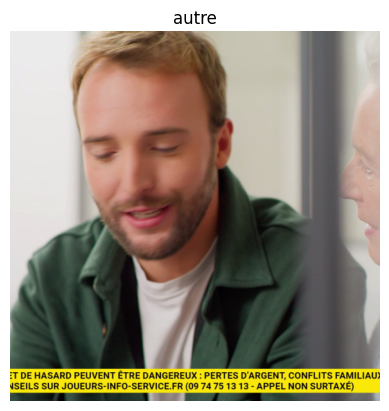

In [18]:
###### Fonction d'affichage ######
def denormalize(img_tensor):
        inverse_normalize = transforms.Normalize(
            mean=[-mean/std, -mean/std, -mean/std],
            std=[1/std, 1/std, 1/std]
        )
        return (inverse_normalize(img_tensor) * 255.).type(torch.uint8).permute(1, 2, 0).numpy()

labels_map = {
    0: "vidmizer" ,
    1: "autre",
}

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

img = images[0]
label = labels[0]
print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show


## Classifier

### Define the Convolutional Neural Network ( Utilisation de ResNet )

In [19]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm



In [20]:
net = torchvision.models.resnet18(weights=None)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
net.fc = nn.Linear(num_ftrs, 2)

In [21]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define a Loss function and optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)

In [23]:
num_class = 2

def quality_measurement(confusion_matrix):
    line_sum=torch.sum(confusion_matrix,dim=1)
    column_sum = torch.sum(confusion_matrix, dim=0)
    total_sum=torch.sum(confusion_matrix)
    Accuracy=torch.sum(torch.diag(confusion_matrix))/total_sum
    Precision=torch.diag(confusion_matrix)/line_sum
    Recall=torch.diag(confusion_matrix)/column_sum
    F1_score = 2 * (Precision * Recall)/(Precision+Recall)
    Pfa=(line_sum - torch.diag(confusion_matrix))/total_sum
    Pmd=(column_sum - torch.diag(confusion_matrix))/total_sum
    print("Accuracy : {}".format(Accuracy.item()))
    print("Precision 0 : {} - Precision 1 : {}".format(Precision[0],Precision[1]))
    print("Recall 0 : {} - Recall 1 : {}".format(Recall[0], Recall[1]))
    print("F1 score 0 : {} - F1 score 1 : {}".format(F1_score[0], F1_score[1]))
    print("Pfa 0 : {} - Pfa 1 : {}".format(Pfa[0], Pfa[1]))
    print("Pmd 0 : {} - Pmd 1 : {}".format(Pmd[0], Pmd[1]))
    return torch.nanmean(Accuracy),torch.nanmean(Precision),torch.nanmean(Recall),torch.nanmean(Recall),torch.nanmean(Pfa),torch.nanmean(Pmd)

def test_accuracy():
  net.eval()
  correct = 0
  total = 0
  confusion_matrix=torch.zeros((num_class,num_class),device=device)
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          images, labels = data

          images = images.to(device)
          labels = labels.to(device)

          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          for i in range(len(labels)):
                label=int(labels[i])
                confusion_matrix[predicted[i],label]=confusion_matrix[predicted[i],label]+1
  net.train()
  print(quality_measurement(confusion_matrix))
  return  correct / total, confusion_matrix

In [24]:
list_lr = [0.1]#, 0.01, 0.001, 0.0001]
loss_saveds=[]
accuracy_saveds=[]
test_accuracy_saveds=[]



for lr_v in list_lr :
  net = torchvision.models.resnet18(weights=None)
  num_ftrs = net.fc.in_features
  net.fc = nn.Linear(num_ftrs, 2)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr_v)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)
  net = net.to(device)
  loss_saved=[]
  accuracy_saved=[]
  test_accuracy_saved=[]


  for epoch in tqdm(range(23)):  # loop over the dataset multiple times

      running_loss = 0.0
      correct = 0
      total = 0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


      loss_saved.append(running_loss/((i+1)*batch_size))
      accuracy_saved.append(correct / total)
      running_loss = 0.0
      scheduler.step()

      test_accuracy_val, matrice_confusion = test_accuracy()
      test_accuracy_saved.append(test_accuracy_val)

  print('Finished Training')
  print('Loss : ' , loss_saved)
  print('Accuracy : ' , accuracy_saved)
  print('Accuracy : ' , test_accuracy_saved)
  print( 'Matrice de confusion : ' , matrice_confusion)
  loss_saveds.append(loss_saved)
  accuracy_saveds.append(accuracy_saved)
  test_accuracy_saveds.append(test_accuracy_saved)
  PATH = f'/content/drive/MyDrive/TSP/HTI/PFE/pfe_papier_{lr_v}_vidmizer.pth'
  torch.save(net.state_dict(), PATH)



  0%|          | 0/23 [00:00<?, ?it/s]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0


  4%|▍         | 1/23 [02:52<1:03:14, 172.48s/it]

(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


  9%|▊         | 2/23 [05:41<59:44, 170.70s/it]  

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 13%|█▎        | 3/23 [08:30<56:31, 169.59s/it]

Accuracy : 0.4803788959980011
Precision 0 : 0.4803788959980011 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.648994505405426 - F1 score 1 : nan
Pfa 0 : 0.5196211338043213 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5196211338043213
(tensor(0.4804, device='cuda:0'), tensor(0.4804, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2598, device='cuda:0'), tensor(0.2598, device='cuda:0'))


 17%|█▋        | 4/23 [11:19<53:37, 169.33s/it]

Accuracy : 0.4803788959980011
Precision 0 : 0.4803788959980011 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.648994505405426 - F1 score 1 : nan
Pfa 0 : 0.5196211338043213 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5196211338043213
(tensor(0.4804, device='cuda:0'), tensor(0.4804, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2598, device='cuda:0'), tensor(0.2598, device='cuda:0'))


 22%|██▏       | 5/23 [14:13<51:23, 171.30s/it]

Accuracy : 0.4803788959980011
Precision 0 : 0.4803788959980011 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.648994505405426 - F1 score 1 : nan
Pfa 0 : 0.5196211338043213 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5196211338043213
(tensor(0.4804, device='cuda:0'), tensor(0.4804, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2598, device='cuda:0'), tensor(0.2598, device='cuda:0'))


 26%|██▌       | 6/23 [17:04<48:29, 171.15s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 30%|███       | 7/23 [19:56<45:42, 171.39s/it]

Accuracy : 0.4803788959980011
Precision 0 : 0.4803788959980011 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.648994505405426 - F1 score 1 : nan
Pfa 0 : 0.5196211338043213 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5196211338043213
(tensor(0.4804, device='cuda:0'), tensor(0.4804, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2598, device='cuda:0'), tensor(0.2598, device='cuda:0'))


 35%|███▍      | 8/23 [22:50<43:04, 172.33s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 39%|███▉      | 9/23 [25:43<40:13, 172.41s/it]

Accuracy : 0.4803788959980011
Precision 0 : 0.4803788959980011 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.648994505405426 - F1 score 1 : nan
Pfa 0 : 0.5196211338043213 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5196211338043213
(tensor(0.4804, device='cuda:0'), tensor(0.4804, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2598, device='cuda:0'), tensor(0.2598, device='cuda:0'))


 43%|████▎     | 10/23 [28:37<37:27, 172.90s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 48%|████▊     | 11/23 [31:29<34:30, 172.55s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 52%|█████▏    | 12/23 [34:20<31:34, 172.27s/it]

Accuracy : 0.4803788959980011
Precision 0 : 0.4803788959980011 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.648994505405426 - F1 score 1 : nan
Pfa 0 : 0.5196211338043213 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5196211338043213
(tensor(0.4804, device='cuda:0'), tensor(0.4804, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2598, device='cuda:0'), tensor(0.2598, device='cuda:0'))


 57%|█████▋    | 13/23 [37:12<28:41, 172.14s/it]

Accuracy : 0.4803788959980011
Precision 0 : 0.4803788959980011 - Precision 1 : nan
Recall 0 : 1.0 - Recall 1 : 0.0
F1 score 0 : 0.648994505405426 - F1 score 1 : nan
Pfa 0 : 0.5196211338043213 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.5196211338043213
(tensor(0.4804, device='cuda:0'), tensor(0.4804, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2598, device='cuda:0'), tensor(0.2598, device='cuda:0'))


 61%|██████    | 14/23 [40:03<25:44, 171.62s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 65%|██████▌   | 15/23 [42:54<22:51, 171.43s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 70%|██████▉   | 16/23 [45:46<20:00, 171.57s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 74%|███████▍  | 17/23 [48:37<17:08, 171.39s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 78%|███████▊  | 18/23 [51:27<14:16, 171.20s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 83%|████████▎ | 19/23 [54:18<11:24, 171.05s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 87%|████████▋ | 20/23 [57:12<08:35, 171.85s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 91%|█████████▏| 21/23 [1:00:03<05:43, 171.74s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


 96%|█████████▌| 22/23 [1:02:56<02:52, 172.14s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))


100%|██████████| 23/23 [1:05:47<00:00, 171.65s/it]

Accuracy : 0.5196211338043213
Precision 0 : nan - Precision 1 : 0.5196211338043213
Recall 0 : 0.0 - Recall 1 : 1.0
F1 score 0 : nan - F1 score 1 : 0.683882474899292
Pfa 0 : 0.0 - Pfa 1 : 0.4803788959980011
Pmd 0 : 0.4803788959980011 - Pmd 1 : 0.0
(tensor(0.5196, device='cuda:0'), tensor(0.5196, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.2402, device='cuda:0'), tensor(0.2402, device='cuda:0'))
Finished Training
Loss :  [0.024225326457425304, 0.011827345168137032, 0.011204339361385159, 0.011484117226918106, 0.010984619067091009, 0.011044242358564035, 0.011028407202304705, 0.011086081681044205, 0.011033399455735216, 0.010888319098107193, 0.010866511147469282, 0.010827096462573694, 0.010824854424952166, 0.010830472081737675, 0.010828465344789236, 0.010828280092581459, 0.010827328037956486, 0.010822352325624746, 0.0108236916889639, 0.010812670863031046, 0.010807754714851793, 0.010805502493420372, 0.010805565195725016]
Accuracy :  [0.49879848

### Print de la loss en fonction des epochs

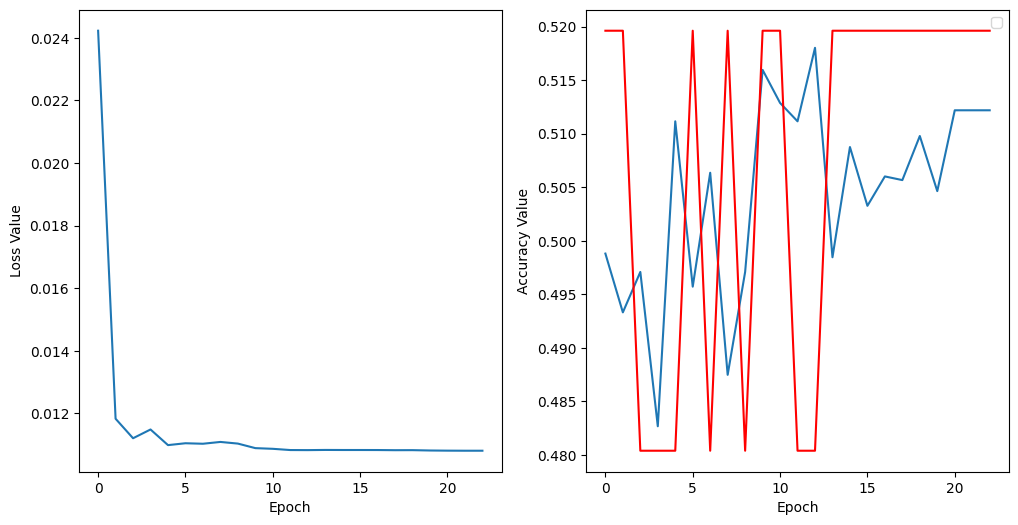

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_saved)
plt.ylabel('Loss Value')
plt.xlabel('Epoch')


plt.subplot(1, 2, 2)
plt.plot(accuracy_saved)
plt.plot(test_accuracy_saved, color='r')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend()

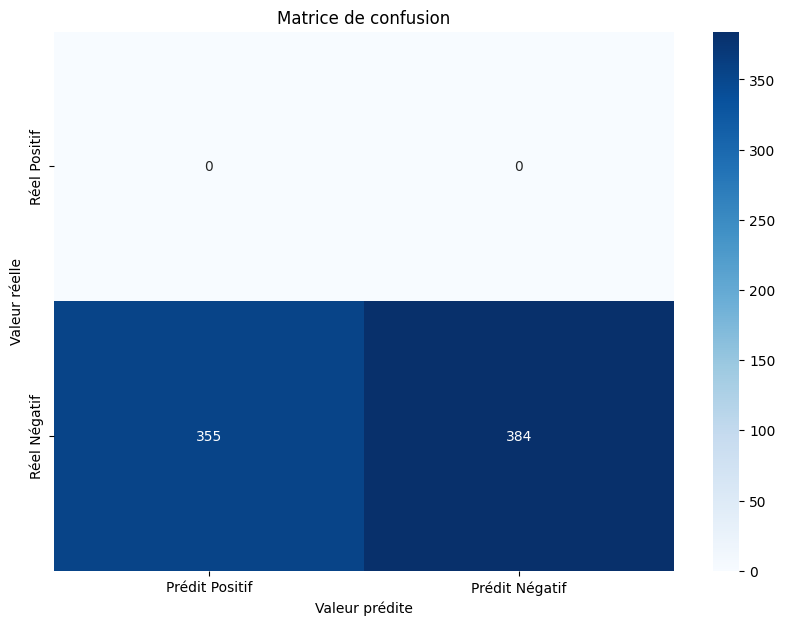

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Données de la matrice de confusion
conf_matrix = [[0, 0], [355, 384]]

# Conversion en DataFrame pour une meilleure visualisation avec Seaborn
df_cm = pd.DataFrame(conf_matrix, index=["Réel Positif", "Réel Négatif"], columns=["Prédit Positif", "Prédit Négatif"])

# Tracé de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.show()


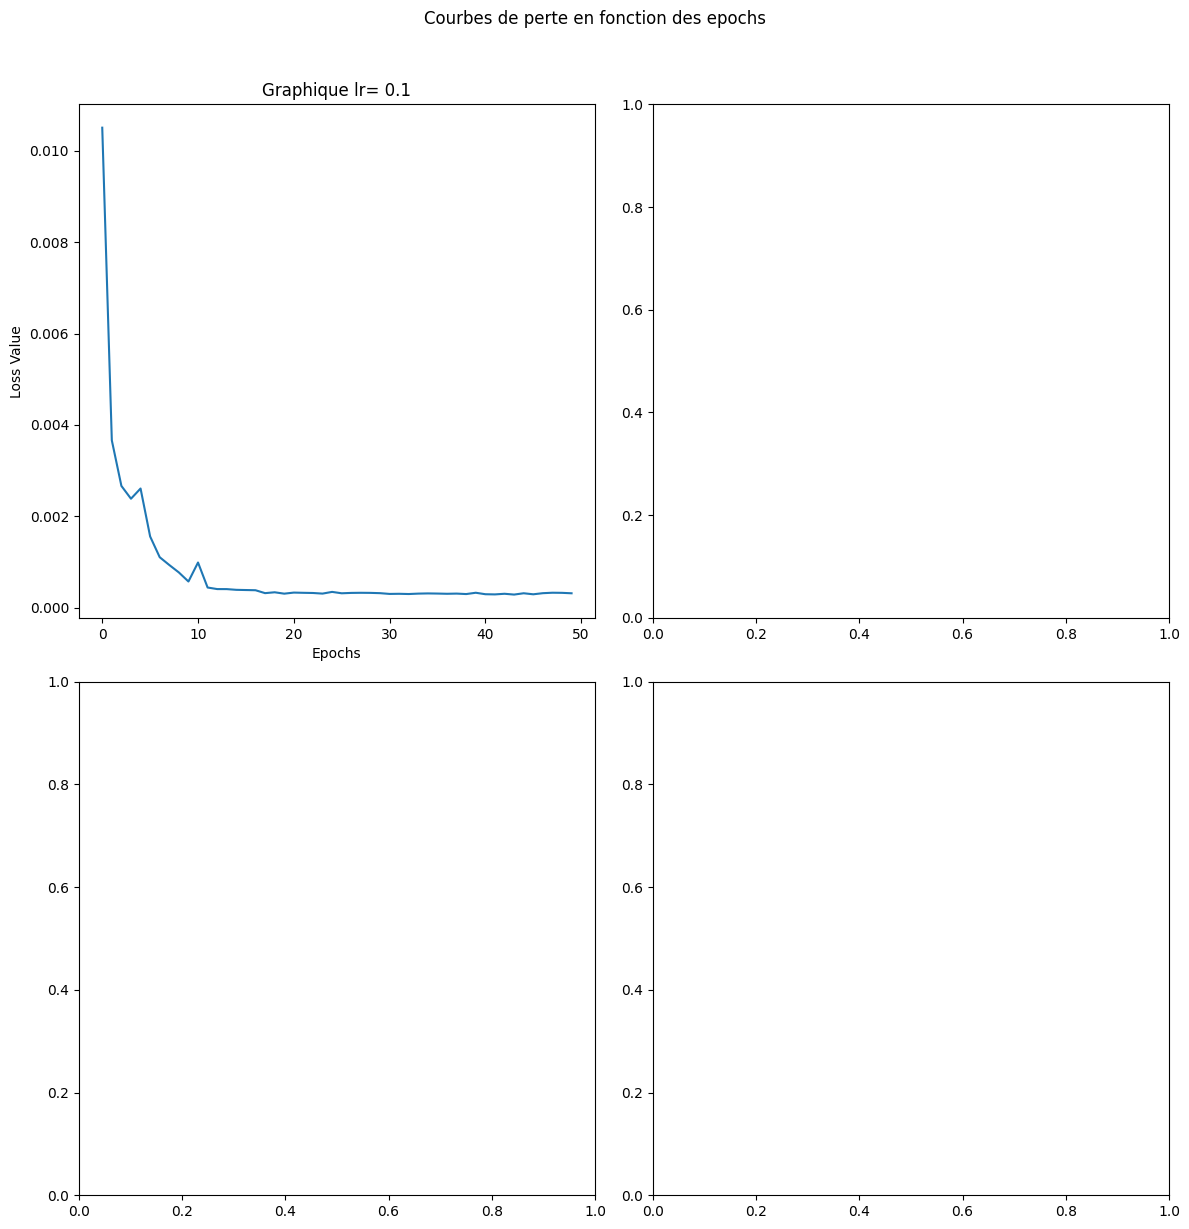

In [ ]:
import matplotlib.pyplot as plt

# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes de perte en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, loss_saved in enumerate(loss_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(loss_saved)


    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss Value')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Print de l'accuracy en fonction des epochs

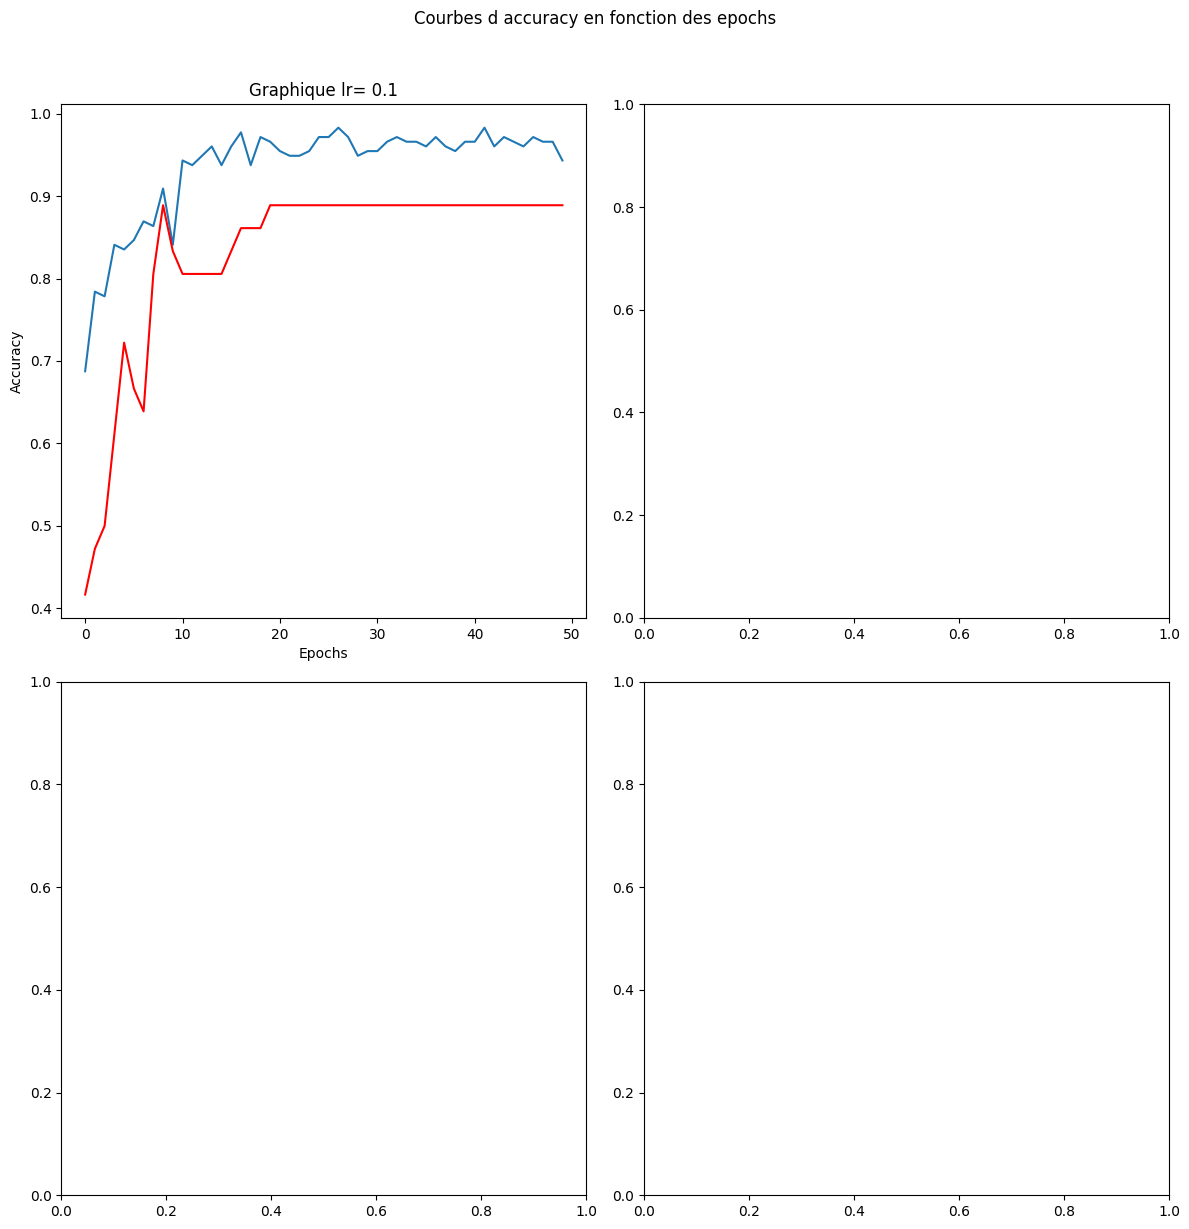

In [ ]:
# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes d accuracy en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, accuracy_saved in enumerate(accuracy_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(accuracy_saved,label='train')
    ax.plot(test_accuracy_saveds[i],color='r',label='test')

    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Test the network on the test data

#### First test on one frame

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

img = images[0].cpu()  # Copie le tensor sur le CPU
label = labels[0].cpu()  # Copie le tensor sur le CPU

print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show

torch.Size([3, 576, 576])


NameError: name 'labels_map' is not defined

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

In [ ]:
predicted = predicted.cpu()  # Copie le tensor sur le CPU
print(labels_map[int(predicted[0].numpy())])


NameError: name 'labels_map' is not defined

#### Let us look at how the network performs on the whole dataset

#### Result by class

In [27]:
classes = ('vidmizer','autre')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)  # Copie les images sur le GPU
        labels = labels.to(device)  # Copie les étiquettes sur le GPU
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: vidmizer is 0.0 %
Accuracy for class: autre is 100.0 %
